In [3]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Part 1: Backpropagation on a mathematical expression

No graphs because I didn't want to install GraphViz software :(

In [4]:
def f(x):
  return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

In [6]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [7]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

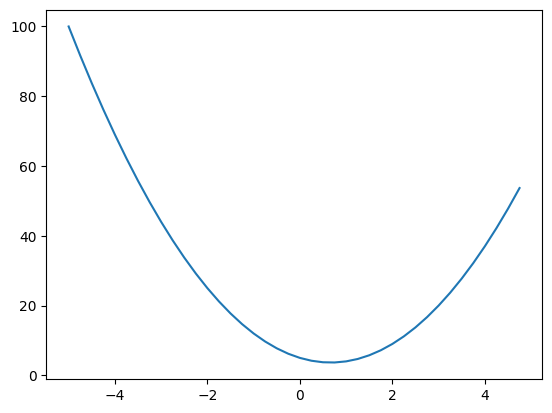

In [8]:
plt.plot(xs, ys)

In [9]:
h = 0.000001
x = 2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [10]:
# more complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# test with a, b, and c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [12]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    # determines return format of a value
    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    def __add__(self, other):
        # if adding Value with constant, wrap constant in Value so addition works
        other = other if isinstance(other, Value) else Value(other)
        # + here is just the regular addition of two floats (not the addition of two Value objects)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            # += for multivarible case
            self.grad += 1.0 * out.grad  #chaining local derivative * global derivative
            other.grad += 1.0 * out.grad
        out._backward = _backward 
                   
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward 
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
    
        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out    
            
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward 
        
        return out
    
    def __radd__(self, other): # other + self (e.g. 2 + a), cannot do int + value, so tries (a + 2), sees that can to value + int (b/c wrapping int in Value in add), so executes a + 2)
        return self * other
    def __rmul__(self, other):
        return self * other
    
    def backward(self):
        topo = []
        visited = set()
        # topological sort so can backpropagate right to left
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
            

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
# internally, python does self.__add__(other) when a+ b called. a is self, b is other
a + b

c = Value(10.0, label="c")
# order of operations work naturally
e = a*b; e.label = "e"
d = e + c; d.label="d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"
L


Value(data=-8.0)

In [13]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [14]:
d._op

'+'

In [15]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label = "e"
    d = e + c; d.label="d"
    f = Value(-2.0, label="f")
    L = d * f; L.label = "L"
    L1 = L.data
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a*b; e.label = "e"
    d = e + c; d.label="d"
    f = Value(-2.0 + h, label="f")
    L = d * f; L.label = "L"
    L2 = L.data 
    
    print((L2 - L1)/h)

lol()

3.9999999999995595


### Part 2: Backpropagation on neurons

In [16]:
#inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"


In [17]:
o.backward()

In [18]:
w1.grad

0.9999999999999998

In [19]:
#inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")
#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1)/(e+1)

o.label = "o"
o.backward()


In [20]:
w1.grad

1.0

### Part 3: Micrograd in PyTorch

In [21]:
import torch 

# .double() makes these float64 tensors, more precise than default float32
x1 = torch.Tensor([2.0]).double()             ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()             ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()            ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()             ; w2.requires_grad = True
b = torch.tensor(6.8813735870195432).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

#.item returns just the elemnt, stripping out the Tensor. o.item() and o.data.item() produces the same result
print(o.data.item())
o.backward()

print("------")

print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [22]:
class Neuron:
    # nin is # of imports to neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1)) 
    
    # method executed when n(...) executed, where n is a Neuron     
    def __call__(self, x):
        # w * x + b. dot product
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        # returns one value as output
        return out
    
    def parameters(self):
      return self.w + [self.b]
      

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters() ]
    
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params
        


class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [23]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.012560572124042728)

In [24]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, 1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets



In [36]:
for k in range(20):
    # making four different forward passes with different starting data through the same MLP
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    for p in n.parameters():
        p.grad = 0.0
    
    loss.backward()
    
    for p in n.parameters():
        p.data += - 0.01 * p.grad
    
    print(k, loss.data)

0 0.017444564182560744
1 0.017334432774513665
2 0.017225637338472002
3 0.017118154180614402
4 0.01701196015672574
5 0.016907032656510515
6 0.016803349588436614
7 0.016700889365088338
8 0.01659963088900872
9 0.016499553539013
10 0.016400637156954494
11 0.016302862034925984
12 0.0162062089028801
13 0.01611065891665271
14 0.016016193646374202
15 0.015922795065254642
16 0.015830445538727995
17 0.015739127813943023
18 0.01564882500958756
19 0.015559520606034393


In [37]:
ypred

[Value(data=0.9729092961210025),
 Value(data=-0.9199454445622172),
 Value(data=-0.9273256979731864),
 Value(data=0.9377968281788716)]